In [ ]:
!pip install -q wordcloud
!pip install -q tqdm
!pip install -q emoji
!pip install -q swifter
!pip install -q sentence-transformers
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import string
import nltk
import gensim
import re
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
import tqdm
import emoji
import swifter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud, ImageColorGenerator
from transformers import BertTokenizer, TFBertModel
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow
from tensorflow import keras
import seaborn as sn
sn.set()

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Dataset**

### **Capturing dataset from Kaggle**

In [ ]:
# !gdown 1R8waoO4GA-0SiyfadnSDcY4FeuNkTV3A
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d kritanjalijain/amazon-reviews
# !unzip /content/amazon-reviews.zip
# os.rename('test.csv', 'Amazon_Review_Test.csv')
# os.rename('train.csv', 'Amazon_Review_Train.csv')
# os.remove("amazon-reviews.zip")

In [ ]:
!gdown 1R8waoO4GA-0SiyfadnSDcY4FeuNkTV3A
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format
!unzip /content/imdb-dataset-sentiment-analysis-in-csv-format.zip
os.rename('Train.csv', 'Train_Dataset.csv')
os.rename('Test.csv', 'Test_Dataset.csv')
os.rename('Valid.csv', 'Validation_Dataset.csv')
os.remove("/content/imdb-dataset-sentiment-analysis-in-csv-format.zip")

Downloading...
From: https://drive.google.com/uc?id=1R8waoO4GA-0SiyfadnSDcY4FeuNkTV3A
To: /content/kaggle.json
100% 73.0/73.0 [00:00<00:00, 300kB/s]
mkdir: cannot create directory ‘/root/.kaggle’: File exists
imdb-dataset-sentiment-analysis-in-csv-format.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/imdb-dataset-sentiment-analysis-in-csv-format.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: Valid.csv               


### **Inroduction**

In [ ]:
train_dataset = pd.read_csv('/content/Train_Dataset.csv')
test_dataset = pd.read_csv('/content/Test_Dataset.csv')
validation_dataset = pd.read_csv('/content/Validation_Dataset.csv')
print(f'There are {len(train_dataset)} samples in the train dataset, {len(test_dataset)} samples in the test dataset, and {len(validation_dataset)} samples in the validation dataset.')

There are 40000 samples in the train dataset, 5000 samples in the test dataset, and 5000 samples in the validation dataset.


In [ ]:
train_dataset.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
test_dataset.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [ ]:
validation_dataset.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


### **Analysis**

In [ ]:
def calculate_positve_percentage(df):
  return round(df['label'].sum()/ len(df), 4) * 100

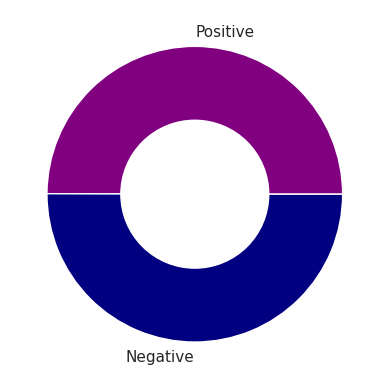

In [ ]:
my_circle=plt.Circle((0,0), 0.5, color='white')
plt.pie([calculate_positve_percentage(train_dataset), 100-calculate_positve_percentage(train_dataset)],
        labels=['Positive', 'Negative'], colors=['purple','navy'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

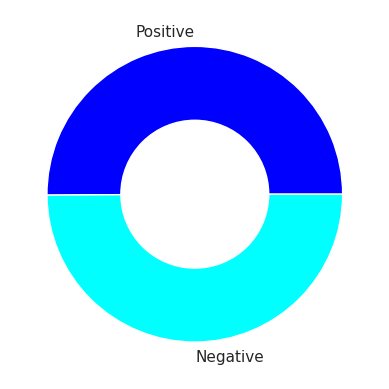

In [ ]:
my_circle=plt.Circle((0,0), 0.5, color='white')
plt.pie([calculate_positve_percentage(test_dataset), 100-calculate_positve_percentage(test_dataset)],
        labels=['Positive', 'Negative'], colors=['blue','cyan'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

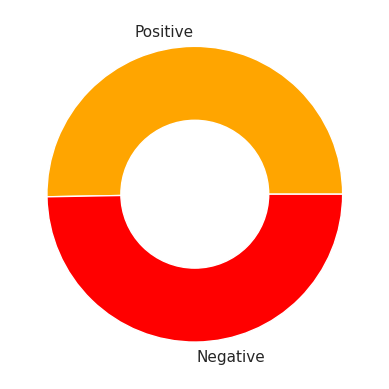

In [ ]:
my_circle=plt.Circle((0,0), 0.5, color='white')
plt.pie([calculate_positve_percentage(validation_dataset), 100-calculate_positve_percentage(validation_dataset)],
        labels=['Positive', 'Negative'], colors=['Orange','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
def create_wordcloud(text, path):
    wc = WordCloud(background_color="white",
    max_words=3000,
    stopwords=stopwords,
    random_state=42,
    width=500, height=500,
    repeat=False)
    wc.generate(str(text))
    wc.to_file(path)
    path=path
    display(Image.open(path))

In [ ]:
# plt.figure(figsize=(15, 8), dpi=320)
# create_wordcloud(test_dataset[test_dataset['label']==1]['text'].values,"all.png")

## **Pre-Processing**

In [ ]:
def process(text,
            remove_punctuaction=True,
            remove_stopwords=True):
  text = text.lower()
  text = emoji.demojize(text)
  text = re.sub(r'(?:\@|https?\://)\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"'s", " ", text)
  text = re.sub(r"'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"'re", " are ", text)
  text = re.sub(r"'d", " would ", text)
  text = re.sub(r"'ll", " will ", text)
  if remove_punctuaction:
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
  if remove_stopwords:
    text = ' '.join([word for word in text.split() if word not in stopwords])
  text = re.sub(' +', ' ', text)
  return text

In [ ]:
# def label_encoding(labels):
#   le = preprocessing.LabelEncoder()
#   return le.fit_transform(labels), list(le.classes_)

In [ ]:
train_dataset['text'] = train_dataset['text'].swifter.apply(lambda x: process(x))
test_dataset['text'] = test_dataset['text'].swifter.apply(lambda x: process(x))
validation_dataset['text'] = validation_dataset['text'].swifter.apply(lambda x: process(x))

Pandas Apply:   0%|          | 0/40000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
x_train_text, y_train = train_dataset['text'].to_numpy(), train_dataset['label'].to_numpy()
x_test_text, y_test = test_dataset['text'].to_numpy(), test_dataset['label'].to_numpy()
x_validation_text, y_validation = validation_dataset['text'].to_numpy(), validation_dataset['label'].to_numpy()

## **Visualization**

In [ ]:
def visulizer(representation, model_name, label):
  pca = PCA(n_components=2)
  representation_reduced = pca.fit_transform(representation)
  plt.figure(figsize=(8,8))
  title= 'Text representation generated by {}'.format(model_name)
  plt.title(title)
  sn.scatterplot(x=representation_reduced[:,0], y=representation_reduced[:,-1], hue=label, palette='bright', legend='auto')
  plt.show()
  return

def plot_confusion_matrix(confusion_matrix, title='', cmap ='RdPu'):
    df = pd.DataFrame(confusion_matrix, range(len(confusion_matrix)), range(len(confusion_matrix)))
    plt.figure(figsize=(6,4))
    if title == '' :
        plt.title('Confusion Matrix')
    else:
        plt.title('Confusion Matrix' + ' ' + title)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df, annot=True, annot_kws={"size": 12},fmt='.0f',cmap=cmap) # font size
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_learning_curve(history, model_name):
  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Learning Curves of model using {}'.format(model_name))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  return

## **Text Representation**

### **Text2Sequence**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_text)
X_train = tokenizer.texts_to_sequences(x_train_text)
X_train = pad_sequences(X_train, padding='post', maxlen=300)
X_test = tokenizer.texts_to_sequences(x_test_text)
X_test = pad_sequences(X_test, padding='post', maxlen=300)
X_validation = tokenizer.texts_to_sequences(x_validation_text)
X_validation = pad_sequences(X_validation, padding='post', maxlen=300)

In [ ]:
word_index=tokenizer.word_index
num_words=len(word_index)+1

### **Glove**

In [ ]:
!gdown https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
!unzip /content/glove.42B.300d.zip

Downloading...
From: https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
To: /content/glove.42B.300d.zip
100% 1.88G/1.88G [00:20<00:00, 93.7MB/s]
Archive:  /content/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
embedding_vector_glove = {}
glove_file = open('/content/glove.42B.300d.txt', encoding="utf8")
for line in tqdm.tqdm(glove_file):
  value = line.split(' ')
  word = value[0]
  embedding_vector_glove[word] = np.array(value[1:], dtype='float32')
glove_file.close()

1917495it [02:25, 13195.12it/s]


In [ ]:
embedding_matrix_glove = np.zeros((num_words, 300))
for word, i in tqdm.tqdm(word_index.items()):
  if i > num_words:
      continue
  embedding_vector=embedding_vector_glove.get(word)
  if embedding_vector is not None:
      embedding_matrix_glove[i]=embedding_vector

100%|██████████| 154379/154379 [00:00<00:00, 337394.56it/s]


In [ ]:
del embedding_vector_glove

<ipython-input-52-9d22e1fca359>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sn.scatterplot(x=representation_reduced[:,0], y=representation_reduced[:,-1], hue=label, palette='bright', legend='auto')


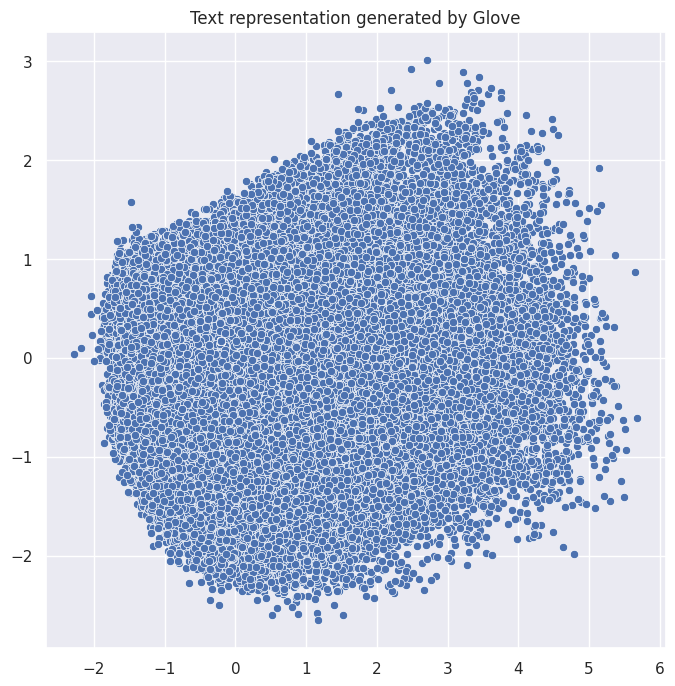

In [ ]:
visulizer(embedding_matrix_glove, model_name='Glove', label=None)

### **Word2vec**

In [ ]:
!pip install -q --upgrade --no-cache-dir gdown
!gdown 0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From (uriginal): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
From (redirected): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t&uuid=3f3e5a5b-f65a-4fcd-8e4d-c231ca499cb5
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:40<00:00, 40.7MB/s]


In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
embedding_matrix_w2v = np.zeros((num_words, 300))
for word, i in tqdm.tqdm(word_index.items()):
  if i > num_words:
      continue
  try:
    embedding_vector=word2vec_model[word]
  except:
    embedding_vector=None
  if embedding_vector is not None:
      embedding_matrix_w2v[i]=embedding_vector

100%|██████████| 154379/154379 [00:00<00:00, 296237.27it/s]


In [ ]:
del word2vec_model

<ipython-input-21-153439e3a206>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sn.scatterplot(x=representation_reduced[:,0], y=representation_reduced[:,-1], hue=label, palette='bright', legend='auto')


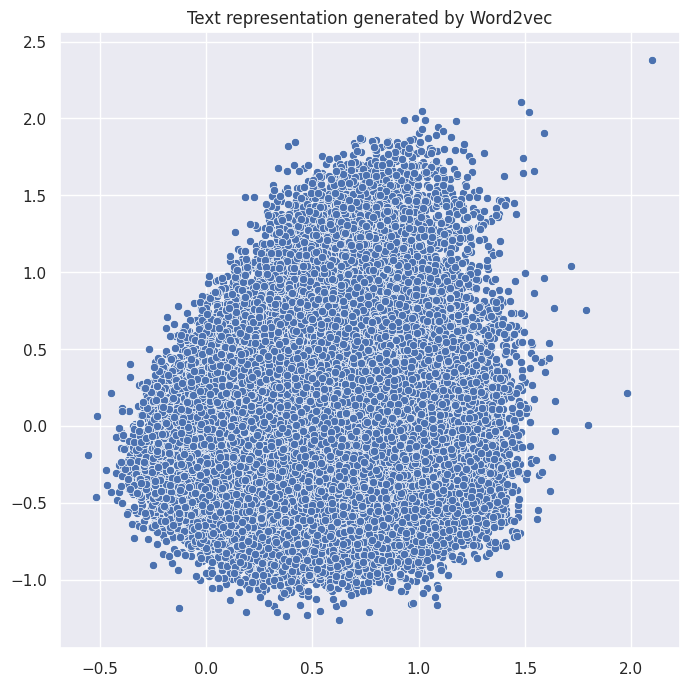

In [ ]:
visulizer(embedding_matrix_w2v, model_name='Word2vec', label=None)

### **Bert Pretrained Embedding**

In [ ]:
if torch.cuda.is_available():
  bert_model = SentenceTransformer('bert-base-uncased',device='cuda')
else:
  bert_model = SentenceTransformer('bert-base-uncased', device='cpu')

In [ ]:
!pip install -q transformers
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")


In [ ]:
embedding_matrix_bert = np.zeros((num_words, 768))
for word, i in tqdm.tqdm(word_index.items()):
  if i > num_words:
      continue
  try:
    encoded_input = bert_tokenizer(word, return_tensors='tf')
    embedding_vector = bert_model(encoded_input)[-1].numpy()[0]
  except:
    embedding_vector=None
  if embedding_vector is not None:
      embedding_matrix_bert[i]=embedding_vector

In [ ]:
embedding_matrix_bert = np.zeros((num_words, 768))
for word, i in tqdm.tqdm(word_index.items()):
  if i > num_words:
      continue
  try:
    embedding_vector = bert_model.encode(word)
  except:
    embedding_vector=None
  if embedding_vector is not None:
      embedding_matrix_bert[i]=embedding_vector

100%|██████████| 154379/154379 [42:47<00:00, 60.12it/s]


In [ ]:
del bert_model

<ipython-input-21-153439e3a206>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sn.scatterplot(x=representation_reduced[:,0], y=representation_reduced[:,-1], hue=label, palette='bright', legend='auto')


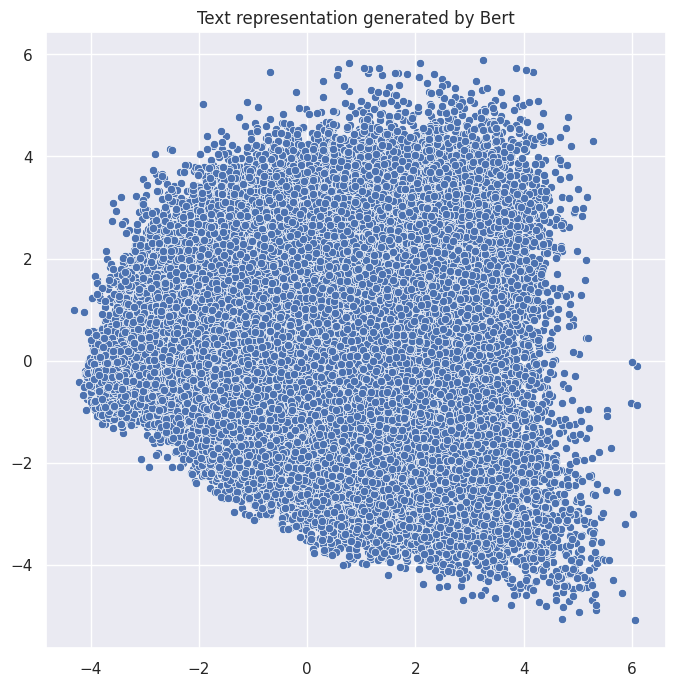

In [ ]:
visulizer(embedding_matrix_bert, model_name='Bert', label=None)

## **Baseline Model**

### **Model Architecture**

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

def build_model(vocab_size,
                input_length,
                embedding_matrix=None,
                output_dim=1,
                kernel_size=3,
                drop_rate=0.2,
                units=128,
                train_embedding=False):

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(None,)))
    #create embedding layer
    if not embedding_matrix is None:
      model.add(keras.layers.Embedding(input_dim = vocab_size,
                          output_dim=embedding_matrix.shape[-1],
                          input_length=input_length,
                          trainable = train_embedding,
                          embeddings_initializer = keras.initializers.Constant(embedding_matrix)
                          ))

      model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units, dropout=0.2)))
    model.add(keras.layers.Dense(units, activation = 'relu'))
    model.add(keras.layers.Dense(units//2, activation = 'relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(output_dim, activation = 'sigmoid'))
    return model


def train_model(model, X_train, y_train, X_validation, y_validation, batch_size=128, epochs=50, learning_rate=0.001):

  model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(
      X_train,
      y_train,
      validation_data=[X_validation, y_validation],
      callbacks=[callback],
      batch_size = batch_size,
      epochs = epochs,
      shuffle = True)
  return history

def Evaluate_model(model, X_test, y_test, batch_size=128, title=''):
  prediction_prob = model.predict(X_test, verbose=1, batch_size=batch_size)
  predictions = np.where(prediction_prob < 0.5, 0, 1)
  plot_confusion_matrix(confusion_matrix(y_test, predictions), title=title, cmap ='Greens')
  report = classification_report(y_test, predictions, target_names=['Negative', 'Positive'], output_dict=True)
  print(classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
  macro_precision =  report['macro avg']['precision']
  macro_recall = report['macro avg']['recall']
  macro_f1 = report['macro avg']['f1-score']
  return macro_precision, macro_recall, macro_f1

### **Model Training & Evaluation**

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         46314000  
                                                                 
 dropout_8 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                     

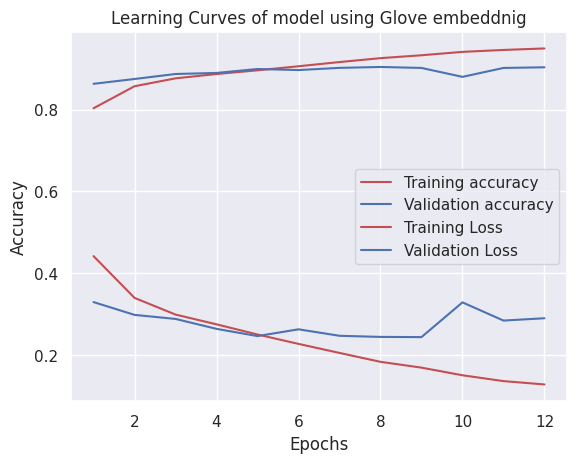

79/79 [==============================] - 2s 13ms/step


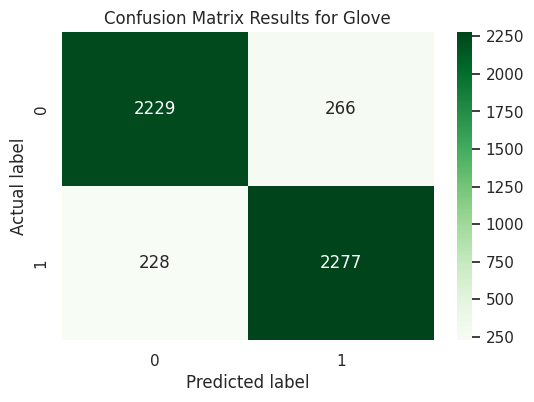

              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      2495
    Positive       0.90      0.91      0.90      2505

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [ ]:
model = build_model(vocab_size=num_words, input_length=X_train.shape[1], embedding_matrix=embedding_matrix_glove)
history = train_model(model, X_train, y_train, X_validation, y_validation, batch_size=64, epochs=20)
plot_learning_curve(history, model_name='Glove embeddnig')
macro_precision_glove, macro_recall_glove, macro_f1_glove = Evaluate_model(model, X_test, y_test, batch_size=64, title='Results for Glove')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         46314000  
                                                                 
 dropout_10 (Dropout)        (None, None, 300)         0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                     

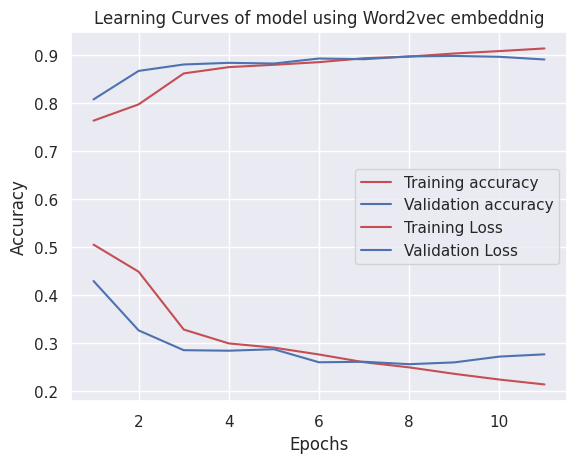

79/79 [==============================] - 2s 14ms/step


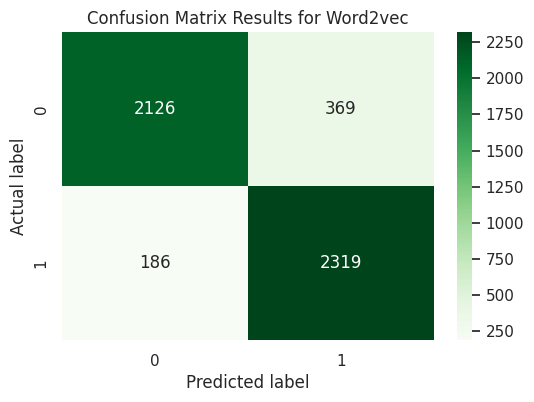

              precision    recall  f1-score   support

    Negative       0.92      0.85      0.88      2495
    Positive       0.86      0.93      0.89      2505

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [ ]:
model = build_model(vocab_size=num_words, input_length=X_train.shape[1], embedding_matrix=embedding_matrix_w2v)
history = train_model(model, X_train, y_train, X_validation, y_validation, batch_size=64, epochs=20)
plot_learning_curve(history, model_name='Word2vec embeddnig')
macro_precision_w2v, macro_recall_w2v, macro_f1_w2v = Evaluate_model(model, X_test, y_test, batch_size=64, title='Results for Word2vec')

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 768)         118563840 
                                                                 
 dropout_14 (Dropout)        (None, None, 768)         0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              918528    
 onal)                                                           
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                     

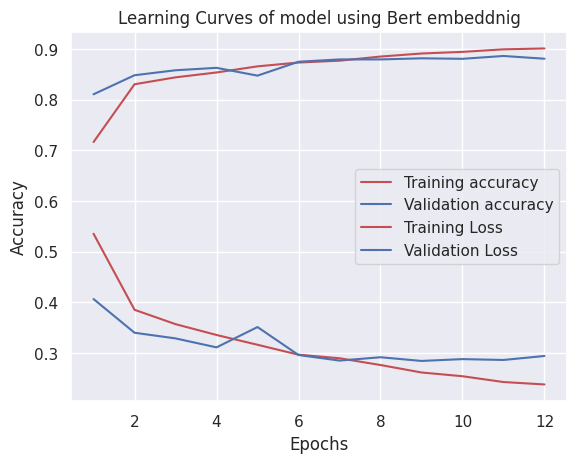

79/79 [==============================] - 2s 20ms/step


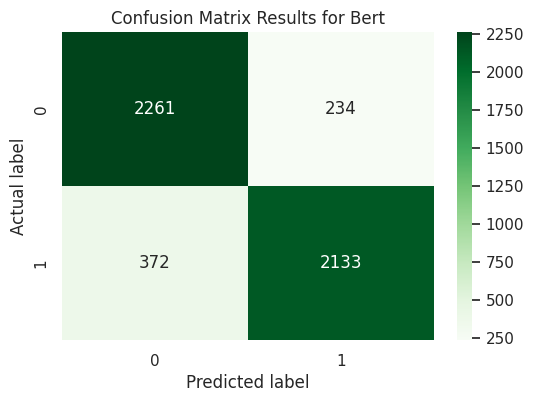

              precision    recall  f1-score   support

    Negative       0.86      0.91      0.88      2495
    Positive       0.90      0.85      0.88      2505

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [ ]:
model = build_model(vocab_size=num_words, input_length=X_train.shape[1], embedding_matrix=embedding_matrix_bert)
history = train_model(model, X_train, y_train, X_validation, y_validation, batch_size=64, epochs=20)
plot_learning_curve(history, model_name='Bert embeddnig')
macro_precision_bert, macro_recall_bert, macro_f1_bert = Evaluate_model(model, X_test, y_test, batch_size=64, title='Results for Bert')

In [ ]:
# model.save("Bert_model.h5")
# from keras.models import load_model
# model = load_model('Bert_model.h5')

### **Comparison Study**

In [ ]:
conclusion = pd.DataFrame([
    ['Glove', macro_precision_glove, macro_recall_glove, macro_f1_glove],
    ['Word2vec', macro_precision_w2v, macro_recall_w2v, macro_f1_w2v],
    ['BERT', macro_precision_bert, macro_recall_bert, macro_f1_bert]
    ],
                          columns=["Word Embedding","Macro Averaged Precision","Macro Averaged Recall","Macro Averaged F1-Score"])
conclusion = conclusion.set_index('Word Embedding')
conclusion.style.background_gradient(cmap="BuGn")


,Macro Averaged Precision,Macro Averaged Recall,Macro Averaged F1-Score
Word Embedding,,,
Glove,0.901302,0.901184,0.901191
Word2vec,0.891137,0.888926,0.888834
BERT,0.879928,0.878855,0.878721
